In [1506]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random


from termcolor import colored

from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer


from mlxtend.evaluate import bias_variance_decomp

# Model
# --------------------------------------------------------------------
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics

In [1507]:
def ROC(X_test,y_test):
    y_pred_proba = model.predict_proba(X_test)
    lr_probs = y_pred_proba[:,1]
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = metrics.roc_auc_score(y_test, ns_probs)
    lr_auc = metrics.roc_auc_score(y_test, lr_probs)
    ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
    lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)
    plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='DT')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Treeb: ROC AUC=%.3f' % (lr_auc))

Imprime las metricas de los modelos

In [1508]:
def metricas(validacion, prediccion, churm):
    
    print("Exactitud: ", metrics.accuracy_score(validacion, prediccion))
    print("Kappa: ", metrics.cohen_kappa_score(validacion, prediccion))
    
    print(colored('Metricas de los registros mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[1], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[1], average='macro'))
    
    VN = churm[0,0]
    FP = churm[0,1]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[1], average='macro'))
    
    
    print(colored('Metricas de los registros no mineros', attrs=['bold']))
    
    print("Precisión: ",  metrics.precision_score(validacion, prediccion, labels=[0], average='macro'))
    print("Recall: ",  metrics.recall_score(validacion, prediccion, labels=[0], average='macro'))
    
    VN = churm[1,1]
    FP = churm[1,0]
    specificity = VN/(VN+FP)
    
    print("Especificidad : ", specificity)
    print("F1-score      : ", metrics.f1_score(validacion, prediccion, labels=[0], average='macro'))

In [1509]:
def matriz_confusion(validacion, prediccion, cmap):
    print(colored('Matriz de confusión', attrs=['bold']))
    churm = metrics.confusion_matrix(validacion, prediccion)
    plt.imshow(churm, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Not_mine','Mine'])
    plt.yticks(tick_marks, ['Not_mine','Mine'])
    return churm

# Importar datos Puros

In [1510]:
dataA = pd.read_csv('./data_identificada.csv').drop(['Second_Protocol', 'Third_Protocol','Cryptocurrency'], axis = 1)
dataA.head(1)

,Netflows,First_Protocol,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,...,first_dp,second_dp,third_dp,p1_ip,p2_ip,p3_ip,p1_ib,p2_ib,p3_ib,Type
0,82,TCP,2.9595,103.6315,135.19425,6709.539,184.327,0.0,407,1266,...,443,5355.0,80.0,3.0,5.0,5.75,84.0,160.0,248.0,not_mine


# Preprocesamiento

### Imputación de valores ausentes

In [1511]:
punter = pd.concat([dataA['second_sp'],dataA['second_dp'],dataA['third_sp'],dataA['third_dp']],axis=1)
imputer = SimpleImputer(missing_values = np.nan, strategy = "median")
values = imputer.fit_transform(punter)

In [1512]:
punter = pd.DataFrame(values, columns = punter.columns)
dataA['second_sp'] = punter['second_sp']
dataA['second_dp'] = punter['second_dp']
dataA['third_sp'] = punter['third_sp']
dataA['third_dp'] = punter['third_dp']

In [1513]:
dataCopyA = dataA
dataA.shape

(4733, 28)

In [1514]:
print(colored('Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo', attrs=['bold']))
porcion_no_minera_conjuntoA = dataCopyA[dataCopyA.Type == "not_mine"]
porcion_no_minera_conjuntoA = porcion_no_minera_conjuntoA.sample(n=750)

Como los registros benignos son los mismos para cada conjunto de datos, sacare aleatoriamente el 70% para utilizarlos para el entreno de modelos posteriores, y emular con el 30% datos de testeo


In [1515]:
porcion_no_minera_conjuntoA.shape

(750, 28)

In [1516]:
dataA.shape

(4733, 28)

In [1517]:
dataA = dataA[~dataA.index.isin(porcion_no_minera_conjuntoA.index)]

Balance del conjunto de datos


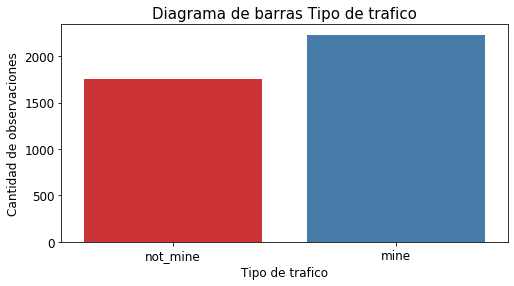

In [1518]:
print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type', data=dataA, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

### OneHotEncoder

In [1519]:
data_categoric = dataA[dataA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<3983x5 sparse matrix of type '<class 'numpy.float64'>'
	with 7966 stored elements in Compressed Sparse Row format>

In [1520]:
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine
0,0,1,0,0,1
1,0,1,0,0,1


In [1521]:
dataA = dataA.drop(['First_Protocol','Type'],axis = 1)

In [1522]:
dataA = pd.concat([dataA,data_dummy], axis = 1)
dataA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_TCP', 'First_Protocol_UDP',
       'Type_mine', 'Type_not_mine'],
      dtype='object')

# Árbol de decisión

In [1523]:
best_feature_pure = ['Avg_bps','Avg_bpp' ,'Avg_pps','p3_ip','p3_ib']

In [1524]:
y = dataA['Type_mine']
X = dataA[best_feature_pure]

### Holdout

In [1525]:
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.7)

### Modelo

In [1526]:
print(colored('Instancio el modelo de arbol de decisión', attrs=['bold']))
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

Instancio el modelo de arbol de decisión


In [1527]:
print(colored('Entreno el modelo', attrs=['bold']))
model.fit(X_train,y_train)

Entreno el modelo


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Grafico el modelo
Profundidad del árbol: 5
Número de nodos terminales: 15


[Text(298.02272727272725, 498.3, 'Avg_pps <= 1.5\nsamples = 2788\nvalue = [1220, 1568]\nclass = i'),
 Text(139.5, 407.70000000000005, 'p3_ib <= 702.5\nsamples = 1835\nvalue = [278, 1557]\nclass = i'),
 Text(76.0909090909091, 317.1, 'Avg_bps <= 71.5\nsamples = 283\nvalue = [276, 7]\nclass = T'),
 Text(50.72727272727273, 226.5, 'p3_ib <= 150.75\nsamples = 9\nvalue = [2, 7]\nclass = i'),
 Text(25.363636363636363, 135.89999999999998, 'samples = 2\nvalue = [2, 0]\nclass = T'),
 Text(76.0909090909091, 135.89999999999998, 'samples = 7\nvalue = [0, 7]\nclass = i'),
 Text(101.45454545454545, 226.5, 'samples = 274\nvalue = [274, 0]\nclass = T'),
 Text(202.9090909090909, 317.1, 'p3_ib <= 801.375\nsamples = 1552\nvalue = [2, 1550]\nclass = i'),
 Text(152.1818181818182, 226.5, 'p3_ib <= 756.375\nsamples = 4\nvalue = [1, 3]\nclass = i'),
 Text(126.81818181818181, 135.89999999999998, 'samples = 3\nvalue = [0, 3]\nclass = i'),
 Text(177.54545454545453, 135.89999999999998, 'samples = 1\nvalue = [1, 0]\

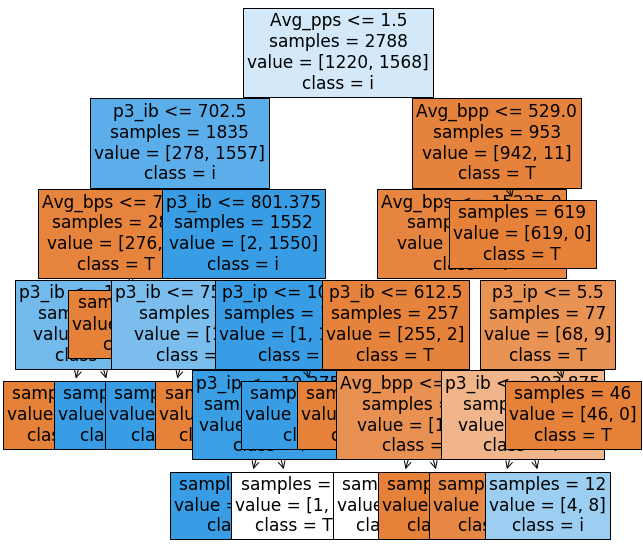

In [1528]:
print(colored('Grafico el modelo', attrs=['bold']))
fig, ax = plt.subplots(figsize = (10,10))

print(colored(f'Profundidad del árbol: {model.get_depth()}', attrs=['bold']))
print(colored(f'Número de nodos terminales: {model.get_n_leaves()}', attrs=['bold']))


plot_tree(
    decision_tree = model,
    feature_names = X_train.columns.tolist(),
    class_names   = 'Tipo de trafico minero',
    filled        = True,
    impurity      = False,
    fontsize      = 17,
    ax            = ax
)

In [1529]:
print(colored('Realizo la predicción del modelo con la porción de prueba', attrs=['bold']))
y_pred = model.predict(X_test)
y_pred

Realizo la predicción del modelo con la porción de prueba


array([0, 1, 1, ..., 0, 1, 1], dtype=uint8)

In [1530]:
len(y_pred[y_pred == 0])

531

In [1531]:
len(y_pred[y_pred == 1])

664

In [1532]:
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(model, np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), loss='0-1_loss')

print('Average expected loss: %.3f' % avg_expected_loss)
print('Average bias: %.3f' % avg_bias)
print('Average variance: %.3f' % avg_var)

Average expected loss: 0.008
Average bias: 0.005
Average variance: 0.004


### Métricas y matriz de confusión

Matriz de confusión


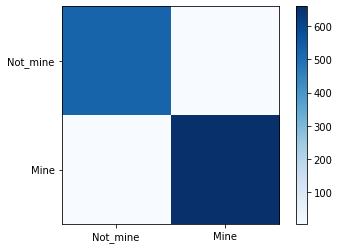

In [1533]:
churm = matriz_confusion(y_test, y_pred, plt.cm.Blues)

In [1534]:
pd.DataFrame(churm)

,0,1
0,527,4
1,4,660


In [1535]:
print("El modelo arbol de dicición se equivocó en %d de los %d registros que componen el dataset de mineria no pura"
      % ((y_test != y_pred).sum(), dataA.shape[0]))

El modelo arbol de dicición se equivocó en 8 de los 3983 registros que componen el dataset de mineria no pura


In [1536]:
metricas(y_test, y_pred, churm)

Exactitud:  0.9933054393305439
Kappa:  0.9864429469289587
Metricas de los registros mineros
Precisión:  0.9939759036144579
Recall:  0.9939759036144579
Especificidad :  0.992467043314501
F1-score      :  0.9939759036144579
Metricas de los registros no mineros
Precisión:  0.992467043314501
Recall:  0.992467043314501
Especificidad :  0.9939759036144579
F1-score      :  0.992467043314501


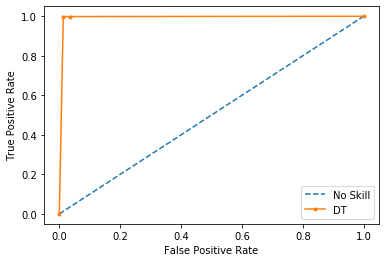

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.993


In [1537]:
ROC(X_test,y_test)

# Experimento 1

In [1538]:
print(colored('Importo el conjunto de datos no puros', attrs=['bold']))
dataB = pd.read_csv('./data_no_identificada.csv').drop(['Name','Second_Protocol', 'Third_Protocol'], axis = 1)
dataB.columns

Importo el conjunto de datos no puros


Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [1539]:
dataB = pd.concat([dataB[dataB.Type == 'mine'],porcion_no_minera_conjuntoA], axis = 0)

### Imputar valores

In [1540]:
punter = pd.concat([dataB['second_sp'],dataB['third_sp'],dataB['second_dp'],dataB['third_dp']], axis = 1)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
values = imputer.fit_transform(punter)

In [1541]:
punter = pd.DataFrame(values, columns = punter.columns)
dataB['second_sp'] = punter['second_sp']
dataB['second_dp'] = punter['second_dp']
dataB['third_sp'] = punter['third_sp']
dataB['third_dp'] = punter['third_dp']

### OneHotEncoder

In [1542]:
data_categoric = dataB[dataB.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)

<37803x6 sparse matrix of type '<class 'numpy.float64'>'
	with 75606 stored elements in Compressed Sparse Row format>

In [1543]:
data_dummy = pd.get_dummies(data_categoric).drop('Type_not_mine',axis=1)
data_dummy.head(2)

,First_Protocol_ICMP,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_mine
0,0,0,1,0,1
1,0,0,1,0,1


In [1544]:
dataB = pd.concat([dataB,data_dummy], axis = 1).drop(['First_Protocol','Type'],axis=1)
dataB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [1545]:
X_train.columns

Index(['Avg_bps', 'Avg_bpp', 'Avg_pps', 'p3_ip', 'p3_ib'], dtype='object')

In [1546]:
X = dataB[best_feature_pure]
y = dataB['Type_mine']

### Realizo la predicción

In [1547]:
y_pred = model.predict(X)
y_pred

array([0, 0, 1, ..., 0, 0, 0], dtype=uint8)

Matriz de confusión


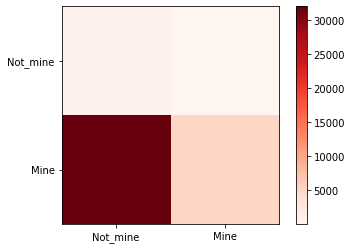

In [1548]:
churm = matriz_confusion(y, y_pred, plt.cm.Reds)

In [1549]:
pd.DataFrame(churm)

,0,1
0,742,8
1,31984,5069


In [1550]:
print("El modelo de en el experimento 1 se equivocó en %d de los %d registros que componen el dataset de mineria no pura"
      % ((y != y_pred).sum(), dataB.shape[0]))

El modelo de en el experimento 1 se equivocó en 31992 de los 37803 registros que componen el dataset de mineria no pura


In [1551]:
metricas(y, y_pred, churm)

Exactitud:  0.15371795889215142
Kappa:  0.0057634229137192294
Metricas de los registros mineros
Precisión:  0.9984242662989955
Recall:  0.1368040374598548
Especificidad :  0.9893333333333333
F1-score      :  0.240636126275813
Metricas de los registros no mineros
Precisión:  0.022673103954042657
Recall:  0.9893333333333333
Especificidad :  0.1368040374598548
F1-score      :  0.04433026645955311


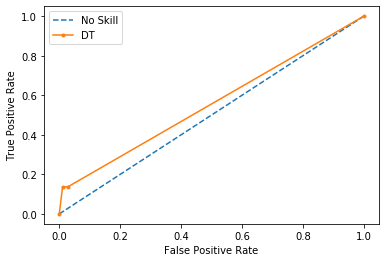

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.556


In [1552]:
ROC(X,y)

# Experimento 2

In [1553]:
print(colored('Caracteristicas del conjunto de datos no puro', attrs=['bold']))
best_feature_noPure = ['min_d', 'first_sp', 'third_sp', 'first_dp', 'third_dp', 'second_sp','second_dp','Type_mine']
print(best_feature_noPure)

Caracteristicas del conjunto de datos no puro
['min_d', 'first_sp', 'third_sp', 'first_dp', 'third_dp', 'second_sp', 'second_dp', 'Type_mine']


In [1554]:
print(colored('Combino las caracteristicas y agrego la variable objetivo', attrs=['bold']))
bestFeature = np.concatenate([best_feature_pure,best_feature_noPure])
bestFeature = np.unique(bestFeature)
bestFeature

Combino las caracteristicas y agrego la variable objetivo


array(['Avg_bpp', 'Avg_bps', 'Avg_pps', 'Type_mine', 'first_dp',
       'first_sp', 'min_d', 'p3_ib', 'p3_ip', 'second_dp', 'second_sp',
       'third_dp', 'third_sp'], dtype='<U9')

In [1555]:
print(colored('Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos', attrs=['bold']))
porcion_minera_conjuntoB = dataB[dataB.Type_mine == 1]
porcion_minera_conjuntoB = porcion_minera_conjuntoB.sample(n=dataCopyA[dataCopyA.Type == "mine"].shape[0])

Aplico una tecnica de submuestreo para equilibrar las clases del conjunto de datos no puros,  con la finalidad de balanciar el conjunto de datos


In [1556]:
print(colored('Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros', attrs=['bold']))


Unimos los conjuntos de datos y aplicamos aleatoriedad en la posición de los registros


In [1557]:
copy_porcion_minera_conjuntoB = porcion_minera_conjuntoB 

In [1558]:
data_final = pd.concat([dataA[bestFeature], porcion_minera_conjuntoB[bestFeature], ], axis = 0)
data_final.shape

(6215, 13)

Balance del conjunto de datos


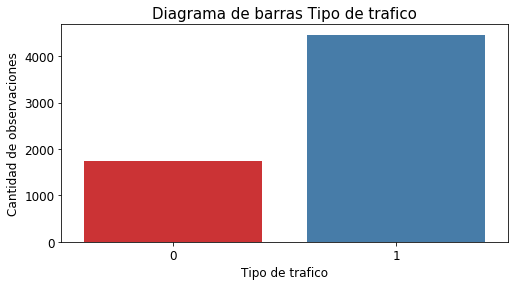

In [1559]:
print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type_mine', data=data_final, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

In [1560]:
sobre_muestreo_no_minera = data_final[data_final.Type_mine == 0]
data_final = pd.concat([data_final, sobre_muestreo_no_minera], axis = 0)
data_final.shape

(7966, 13)

Balance del conjunto de datos


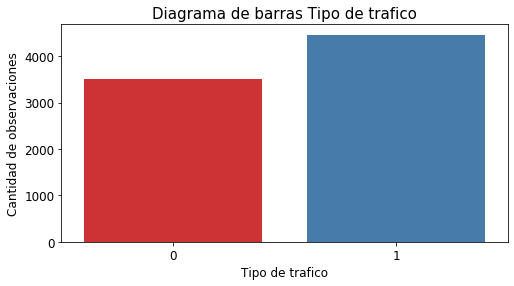

In [1561]:

print(colored(f'Balance del conjunto de datos', attrs=['bold']))
fig, ax = plt.subplots(figsize=(8,4))
ax = sns.countplot(x='Type_mine', data=data_final, palette="Set1")
ax.set_title("Diagrama de barras Tipo de trafico", size=15)
ax.set_xlabel('Tipo de trafico', size = 12)
ax.set_ylabel('Cantidad de observaciones',  size = 12)
ax.tick_params(labelsize = 12)

In [1562]:
print(colored('Aleatoriedad', attrs=['bold']))
data_final = data_final.reset_index()
indices = list(data_final.index)
random.shuffle(indices)
data_final = data_final.reindex(indices)
data_final.head()

Aleatoriedad


,index,Avg_bpp,Avg_bps,Avg_pps,Type_mine,first_dp,first_sp,min_d,p3_ib,p3_ip,second_dp,second_sp,third_dp,third_sp
5716,3500,84,95,0,1,34560,0,0.00,696.00,4.0,1900.0,62760.0,137.0,62759.0
4093,25435,87,132,0,1,34560,0,0.00,34.00,1.0,1281.0,3333.0,3333.0,49168.0
1016,1207,536,485,0,1,3337,3337,265.24,11921.25,15.0,49875.0,49875.0,443.0,123.0
6910,1872,75,3384,5,0,53,53,0.00,97.25,1.0,42388.0,42388.0,35046.0,35046.0
4031,9305,138,245,0,1,34560,0,0.00,286.00,2.0,1281.0,17500.0,17500.0,5353.0


In [1563]:
data_final.drop(['index'],axis =1, inplace=True)

In [1564]:
data_final['Type_mine'] = data_final['Type_mine'].astype('int')

In [1565]:
data_final.shape

(7966, 13)

### Modelo

In [1566]:
X = data_final.drop('Type_mine', axis = 1)
y = data_final['Type_mine']

In [1567]:
model = DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=5,      
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=None,  
    max_leaf_nodes=None, 
    min_impurity_decrease=0.0, 
    class_weight=None)

In [1568]:
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
scores = cross_validate(model, X, y, scoring=scoring, cv=10, return_train_score=False)

for key in scores:
    score = scores[key]
    print("%s: %0.2f (+/- %0.2f)" % (key, score.mean(), score.std() * 2))


fit_time: 0.06 (+/- 0.00)
score_time: 0.02 (+/- 0.00)
test_accuracy: 1.00 (+/- 0.00)
test_precision_weighted: 1.00 (+/- 0.00)
test_recall_weighted: 1.00 (+/- 0.00)
test_f1_weighted: 1.00 (+/- 0.00)


### Cross Validation-K_fold

In [1569]:
K_fold = KFold(n_splits = 10)

In [1570]:
resultados_train = []
resultados_test = []
predicciones = []
scores = []
modelos = []


for result in K_fold.split(X):
    resultados_train.append(result[0])
    resultados_test.append(result[1])
    X_train = X.iloc[result[0]]
    X_test =  X.iloc[result[1]]
    y_train =  y.iloc[result[0]]
    y_test =  y.iloc[result[1]]
    model = model.fit(X_train,y_train)
    modelos.append(model)
    predic = model.predict(X_test)
    predicciones.append(predic)
    scores.append(model.score(X_test, y_test))

In [1571]:
scores

[0.9962358845671268,
 0.998745294855709,
 1.0,
 0.9974905897114178,
 1.0,
 0.9962358845671268,
 0.9974874371859297,
 0.9987437185929648,
 0.9974874371859297,
 0.9974874371859297]

Matriz de confusión


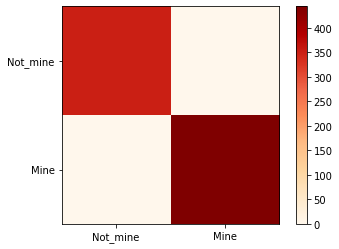

In [1572]:
churm = matriz_confusion(y.iloc[resultados_test[1]], predicciones[1], plt.cm.OrRd)

In [1573]:
pd.DataFrame(churm)

,0,1
0,352,0
1,1,444


In [1574]:
metricas(y.iloc[resultados_test[1]], predicciones[1], churm)

Exactitud:  0.998745294855709
Kappa:  0.9974567049490544
Metricas de los registros mineros
Precisión:  1.0
Recall:  0.9977528089887641
Especificidad :  1.0
F1-score      :  0.998875140607424
Metricas de los registros no mineros
Precisión:  0.9971671388101983
Recall:  1.0
Especificidad :  0.9977528089887641
F1-score      :  0.9985815602836879


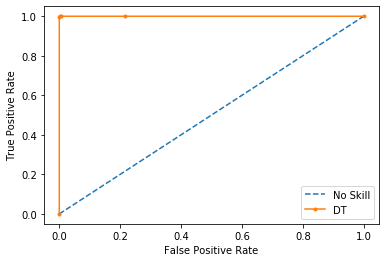

No Skill: ROC AUC=0.500
Treeb: ROC AUC=1.000


In [1575]:
ROC(X.iloc[resultados_test[1]],y.iloc[resultados_test[1]])

### Prueba final

In [1576]:
porcion_no_minera_conjuntoA.columns

Index(['Netflows', 'First_Protocol', 'p1_d', 'p2_d', 'p3_d', 'duration',
       'max_d', 'min_d', '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes',
       '#sp', '#dp', 'first_sp', 'second_sp', 'third_sp', 'first_dp',
       'second_dp', 'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib',
       'p3_ib', 'Type'],
      dtype='object')

In [1577]:
copy_porcion_minera_conjuntoB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [1578]:
data_categoric = porcion_no_minera_conjuntoA[porcion_no_minera_conjuntoA.select_dtypes(include = ['object']).columns.to_list()]
one_hot = OneHotEncoder()
one_hot.fit_transform(data_categoric)
data_dummy = pd.get_dummies(data_categoric)
data_dummy.head(2)

,First_Protocol_ICMP6,First_Protocol_TCP,First_Protocol_UDP,Type_not_mine
4032,0,1,0,1
4306,0,1,0,1


In [1579]:
data_dummy = data_dummy.rename(columns = {'Type_not_mine':'Type_mine'})
data_dummy['Type_mine'] = data_dummy['Type_mine'].replace({1:0})

In [1580]:
porcion_no_minera_conjuntoA = pd.concat([porcion_no_minera_conjuntoA,data_dummy], axis = 1).drop(['First_Protocol'], axis = 1)

In [1581]:
dataB = dataB[~dataB.index.isin(porcion_minera_conjuntoB.index)]

In [1582]:
dataB.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'First_Protocol_ICMP', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [1583]:
porcion_no_minera_conjuntoA.columns

Index(['Netflows', 'p1_d', 'p2_d', 'p3_d', 'duration', 'max_d', 'min_d',
       '#packets', 'Avg_bps', 'Avg_pps', 'Avg_bpp', '#Bytes', '#sp', '#dp',
       'first_sp', 'second_sp', 'third_sp', 'first_dp', 'second_dp',
       'third_dp', 'p1_ip', 'p2_ip', 'p3_ip', 'p1_ib', 'p2_ib', 'p3_ib',
       'Type', 'First_Protocol_ICMP6', 'First_Protocol_TCP',
       'First_Protocol_UDP', 'Type_mine'],
      dtype='object')

In [1584]:
prueba_final = pd.concat([porcion_no_minera_conjuntoA[bestFeature],dataB[bestFeature]], axis = 0).replace({np.nan:0})

In [1585]:
X_p = prueba_final[bestFeature].drop('Type_mine',axis = 1)
y_p = prueba_final['Type_mine']

In [1586]:
y_pred_proba = modelos[1].predict(X_p)

Matriz de confusión


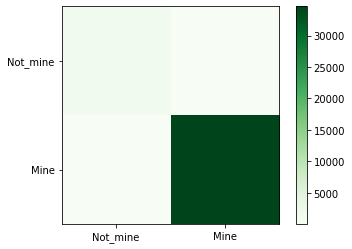

In [1587]:
churm = matriz_confusion(y_p, y_pred_proba, plt.cm.Greens)

In [1588]:
pd.DataFrame(churm)

,0,1
0,1390,60
1,191,34630


In [1589]:
metricas(y_p, y_pred_proba, churm)

Exactitud:  0.9930798709712993
Kappa:  0.9135851459283344
Metricas de los registros mineros
Precisión:  0.9982703949264918
Recall:  0.9945148042847707
Especificidad :  0.9586206896551724
F1-score      :  0.996389060724202
Metricas de los registros no mineros
Precisión:  0.879190385831752
Recall:  0.9586206896551724
Especificidad :  0.9945148042847707
F1-score      :  0.9171890465193004


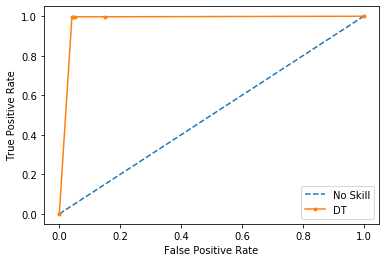

No Skill: ROC AUC=0.500
Treeb: ROC AUC=0.978


In [1590]:
ROC(X_p,y_p)